In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.layers as L
import tensorflow_addons as tfa
import glob, random, os, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print('TensorFlow Version ' + tf.__version__)

TensorFlow Version 2.9.0


In [2]:
image_size = 32
batch_size = 228
n_classes = 33
val_path = '../datasets/input/rotated/val_images'
train_path = '../datasets/input/rotated/train_images'
test_path = '../datasets/input/rotated/test_images'
df_train = '../datasets/input/rotated/csv/train.csv'
df_classes = '../datasets/input/rotated/csv/class.csv'
df_test = '../datasets/input/rotated/csv/test.csv'

In [3]:
df_train = pd.read_csv(df_train, dtype='str')
df_classes = pd.read_csv(df_classes)
df_test = pd.read_csv(df_test, dtype='str')

## Data Augmentation

In [4]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    # # print(image.shape)
 
    # image = tf.image.random_flip_left_right(image)
    # image = tf.image.random_flip_up_down(image)
    
    # if p_spatial > .75:
    #     image = tf.image.transpose(image)
        
    # # Rotates
    # if p_rotate > .75:
    #     image = tf.image.rot90(image, k = 3) # rotate 270º
    # elif p_rotate > .5:
    #     image = tf.image.rot90(image, k = 2) # rotate 180º
    # elif p_rotate > .25:
    #     image = tf.image.rot90(image, k = 1) # rotate 90º
    
    # # print(image.shape)
    return image

## Data Generator

In [5]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(samplewise_center = True,
                                                          samplewise_std_normalization = True,
                                                        #   validation_split = 0.2,
                                                          preprocessing_function = data_augment)

In [6]:
train_gen = datagen.flow_from_dataframe(dataframe = df_train,
                                        directory = train_path,
                                        x_col = 'filename',
                                        y_col = 'label',
                                        batch_size = batch_size,
                                        seed = 1,
                                        color_mode = 'rgb',
                                        shuffle = True,
                                        class_mode = 'categorical',
                                        target_size = (image_size, image_size))

Found 25080 validated image filenames belonging to 33 classes.


c:\Users\Administrator\anaconda3\envs\tensorflow\lib\site-packages\keras\preprocessing\image.py:989: UserWarning: Found 1320 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


In [7]:
valid_gen = datagen.flow_from_dataframe(dataframe = df_train,
                                        directory = val_path,
                                        x_col = 'filename',
                                        y_col = 'label',
                                        batch_size = batch_size,
                                        seed = 1,
                                        color_mode = 'rgb',
                                        shuffle = True,
                                        class_mode = 'categorical',
                                        target_size = (image_size, image_size))

Found 0 validated image filenames belonging to 33 classes.


c:\Users\Administrator\anaconda3\envs\tensorflow\lib\site-packages\keras\preprocessing\image.py:989: UserWarning: Found 25080 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


In [8]:
test_gen = datagen.flow_from_dataframe(dataframe = df_test,
                                       x_col = 'filename',
                                       y_col = 'label',
                                       batch_size = batch_size,
                                       seed = 1,
                                       color_mode = 'rgb',
                                       shuffle = False,
                                       class_mode = None,
                                       target_size = (image_size, image_size))

Found 0 validated image filenames.


c:\Users\Administrator\anaconda3\envs\tensorflow\lib\site-packages\keras\preprocessing\image.py:989: UserWarning: Found 2640 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


### Sample image visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


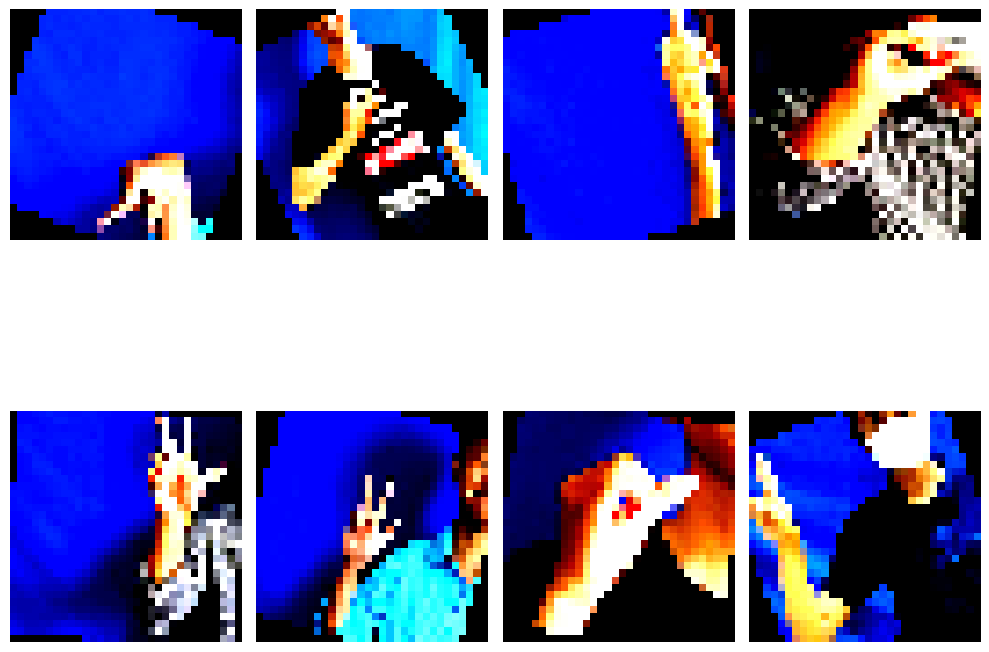

In [9]:
images = np.array([train_gen[0][0][i] for i in range(batch_size)])
fig, axes = plt.subplots(2, 4, figsize = (10, 10))
# print('shape:',images.shape)
# print(images)

axes = axes.flatten()

for img, ax in zip(images, axes):
    # print('gldf',img.shape)
    ax.imshow(img.reshape(image_size, image_size, 3))
    ax.axis('off')

plt.tight_layout()
plt.show()

## Model Hyperparameter

In [10]:
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 32

patch_size = 8 # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

## Building the model and it's components

#### 1. Multilayer Perceptron

In [11]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = L.Dense(units, activation = tf.nn.gelu)(x)
        x = L.Dropout(dropout_rate)(x)
    return x

In [12]:
diag_attn_mask = 1 - tf.eye(num_patches)
diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)

#### 2. Patch creation layer

In [13]:
class Patches(L.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

#### Sample image patches visualization

Image size: 32 X 32
Patch size: 8 X 8
Patches per image: 16
Elements per patch: 192


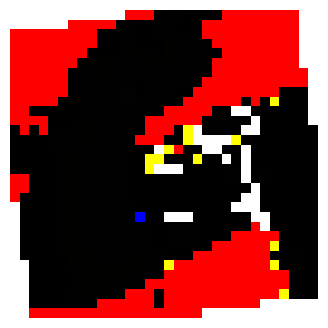

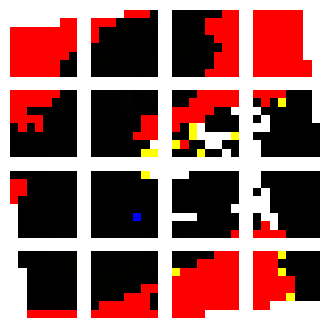

In [14]:
plt.figure(figsize=(4, 4))

x = train_gen.next()
image = x[0][0]

plt.imshow(image.astype('uint8'))
plt.axis('off')

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size = (image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f'Image size: {image_size} X {image_size}')
print(f'Patch size: {patch_size} X {patch_size}')
print(f'Patches per image: {patches.shape[1]}')
print(f'Elements per patch: {patches.shape[-1]}')

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))

for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype('uint8'))
    plt.axis('off')

#### 3. Patch encoding layer

In [15]:
class PatchEncoder(L.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = L.Dense(units = projection_dim)
        self.position_embedding = L.Embedding(
            input_dim = num_patches, output_dim = projection_dim
        )

    def call(self, patch):
        positions = tf.range(start = 0, limit = self.num_patches, delta = 1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

## Build VIT

In [16]:
def vision_transformer(vanilla=False):
    inputs = L.Input(shape = (image_size, image_size, 3))
    
    # Create patches.
    patches = Patches(patch_size)(inputs)
    
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        
        # Layer normalization 1.
        x1 = L.LayerNormalization(epsilon = 1e-6)(encoded_patches)
        
        # Create a multi-head attention layer.
        if not vanilla:
            attention_output = L.MultiHeadAttentionLSA(
                num_heads=num_heads, key_dim=projection_dim, dropout=0.1
            )(x1, x1, attention_mask=diag_attn_mask)
        else:
            attention_output = L.MultiHeadAttention(
                num_heads=num_heads, key_dim=projection_dim, dropout=0.1
            )(x1, x1)
        
        # Skip connection 1.
        x2 = L.Add()([attention_output, encoded_patches])
        
        # Layer normalization 2.
        x3 = L.LayerNormalization(epsilon = 1e-6)(x2)
        
        # MLP.
        x3 = mlp(x3, hidden_units = transformer_units, dropout_rate = 0.1)
        
        # Skip connection 2.
        encoded_patches = L.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = L.LayerNormalization(epsilon = 1e-6)(encoded_patches)
    representation = L.Flatten()(representation)
    representation = L.Dropout(0.3)(representation)
    
    # Add MLP.
    features = mlp(representation, hidden_units = mlp_head_units, dropout_rate = 0.3)
    
    # Classify outputs.
    logits = L.Dense(n_classes)(features)
    
    # Create the model.
    model = tf.keras.Model(inputs = inputs, outputs = logits)
    
    return model

In [17]:
decay_steps = train_gen.n // train_gen.batch_size
initial_learning_rate = learning_rate

lr_decayed_fn = tf.keras.experimental.CosineDecay(initial_learning_rate, decay_steps)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_decayed_fn)

In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

In [20]:
model = vision_transformer(vanilla=True)
model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(), 
              metrics = [
                tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
                tf.keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
              ])
earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                    min_delta = 1e-4,
                                    patience = 400,
                                    mode = 'max',
                                    restore_best_weights = True,
                                    verbose = 1)
STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size
# checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model_sigmoid.h5',
#                                                   monitor = 'val_accuracy', 
#                                                   verbose = 1, 
#                                                   save_best_only = True,
#                                                   save_weights_only = False,
#                                                   mode = 'max')
callbacks = [earlystopping, lr_scheduler]
tf.debugging.set_log_device_placement(True)
try:
    with tf.device('/GPU:0'):
        ViT_Train = model.fit(
            x = train_gen,
            steps_per_epoch = 100,
            validation_data = valid_gen,
            batch_size=batch_size,
            validation_steps = 100,
            epochs = num_epochs,
            callbacks = callbacks
            )
except Exception as e:
    print('Error',e)

Epoch 1/32
100/100 [==============================] - 14s 80ms/step - loss: 6.7790 - accuracy: 0.0413 - top-5-accuracy: 0.1663 - lr: 0.0010
Epoch 2/32
100/100 [==============================] - 9s 86ms/step - loss: 8.3961 - accuracy: 0.0288 - top-5-accuracy: 0.1612 - lr: 1.0000e-03
Epoch 3/32
100/100 [==============================] - 8s 75ms/step - loss: 8.1564 - accuracy: 0.0350 - top-5-accuracy: 0.1475 - lr: 1.0000e-03
Epoch 4/32
100/100 [==============================] - 8s 76ms/step - loss: 7.8906 - accuracy: 0.0237 - top-5-accuracy: 0.1350 - lr: 1.0000e-03
Epoch 5/32
100/100 [==============================] - 7s 74ms/step - loss: 7.9611 - accuracy: 0.0312 - top-5-accuracy: 0.1375 - lr: 1.0000e-03
Epoch 6/32
100/100 [==============================] - 8s 75ms/step - loss: 7.7200 - accuracy: 0.0350 - top-5-accuracy: 0.1612 - lr: 9.9999e-04
Epoch 7/32
100/100 [==============================] - 8s 76ms/step - loss: 7.8600 - accuracy: 0.0237 - top-5-accuracy: 0.1437 - lr: 9.9999e-04
Ep

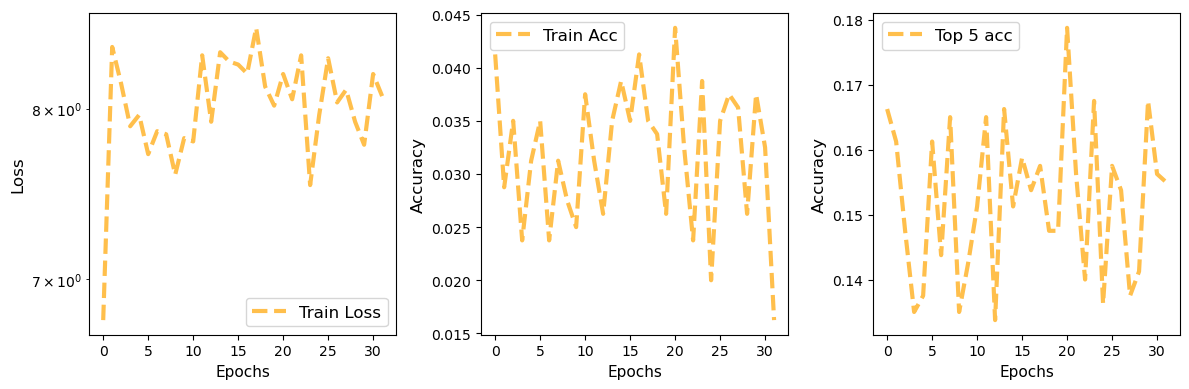

In [23]:
### Plot train and validation curves
loss = ViT_Train.history['loss']
# v_loss = ViT_Train.history['val_loss']

acc = ViT_Train.history['accuracy'] 
# v_acc = ViT_Train.history['val_accuracy']

top5_acc = ViT_Train.history['top-5-accuracy']
# val_top5_acc = ViT_Train.history['val_top5 acc']
epochs = range(len(loss))

fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.yscale('log')
plt.plot(epochs, loss, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Loss')
# plt.plot(epochs, v_loss, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Loss')
# plt.ylim(0.3, 100)
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.subplot(1, 3, 2)
plt.plot(epochs, acc, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Acc')
# plt.plot(epochs, v_acc, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Acc') 
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.subplot(1, 3, 3)
plt.plot(epochs, top5_acc, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Top 5 acc')
# plt.plot(epochs, v_acc, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Acc') 
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
print('Training results')
model.evaluate(train_gen)

print('Validation results')
model.evaluate(valid_gen)

In [ ]:
print('test results')
model.evaluate(test_gen)

In [ ]:

# model.compile(optimizer = optimizer, 
#               loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.1), 
#               metrics = ['accuracy'],
#               )